<a href="https://colab.research.google.com/github/google/evojax/blob/main/examples/notebooks/AbstractPainting02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ES CLIP in JAX - Fitting Abstract Concepts

This Colab notebook is [JAX](https://github.com/google/jax) implementation of **Modern Evolution Strategies for Creativity: Fitting Concrete Images and Abstract Concepts** ([paper](https://arxiv.org/abs/2109.08857), [web](https://es-clip.github.io/), [original code](https://github.com/google/brain-tokyo-workshop/tree/master/es-clip) ).  It is the **Fitting Abstract Concepts** part.

This notebook is designed to leverage accelerators (GPUs/TPUs) and can scale well (almost linearly) with multiple accelerators thanks to JAX, so **(better multiple) accelerators are strongly encouraged**. Although it may still runs with a CPU backend, such enviroment would be extremely slow. To leverage accelerators, you could do **one** of following setting:

- **Using Colab's TPU runtime**: From the Colab menu, choose Runtime > Change Runtime Type, then select 'TPU' in the dropdown. Depending on your  Colab subscription, you may get 1-8 TPUs.
- **Using Colab's GPU runtime**: From the Colab menu, choose Runtime > Change Runtime Type, then select 'GPU' in the dropdown. Depending on your Colab subscription, you may get one GPU with in certain models.
- **Using a local runtime with multiple GPUs**. This is more envolving and needs some tweaking. The official [instructions](https://research.google.com/colaboratory/local-runtimes.html) may be helpful.

The output of in this notebook is from a running on a local runtime with 8 NVIDIA V100 GPUs.

In [ ]:
! nvidia-smi --query-gpu=name --format=csv,noheader

Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB


## Import packages and define utilities

In [ ]:
import datetime
import functools
import pprint
import os
import sys

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

from IPython.display import clear_output
import jax
from jax import lax
from jax import numpy as jnp
import numpy as np
from PIL import Image

if 'COLAB_TPU_ADDR' in os.environ:
  from jax.tools import colab_tpu
  colab_tpu.setup_tpu()

try:
  import drawSvg
except ImportError:
  ! pip install drawSvg
  clear_output()
  import drawSvg

!pip install git+https://github.com/gecco-evojax/evojax.git@main
clear_output()

from evojax.algo.pgpe import PGPE

In [ ]:
# Import CLIP_JAX and patch it

jax_clip_path = 'CLIP_JAX'

try:
  #  These are required by CLIP_JAX.
  import haiku
  import ftfy
except ImportError:
  ! pip install pip install dm-haiku ftfy
  clear_output()
  import haiku
  import ftfy

if not os.path.exists(jax_clip_path):
    !git clone https://github.com/kingoflolz/CLIP_JAX.git

if jax_clip_path not in sys.path:
    sys.path.append(jax_clip_path)

import clip_jax

# Patch the download function so it downloads to a specified directory,
# which in our case is the current working directory.

download_dir = os.getcwd()

if not 'is_patched' in clip_jax.clip._download.__dict__:
  original_fn = clip_jax.clip._download
  new_fn = lambda url: original_fn(url, root=download_dir)
  clip_jax.clip._download = new_fn
  clip_jax.clip._download.is_patched = True

In [ ]:
# JAX based rendering

def quantitize(a, quant):
  return lax.cond(
    quant > 0, 
    lambda v: jnp.rint(v * quant) / quant,
    lambda v: v,
    a
  )

def put_triangle_fn(i_triangle, packed_args):
  canvas, xyv, xy0, xy1, xy2, r, g, b, a, quant = packed_args
  n_batch, h, w = canvas.shape[:3]

  xy0_triangle = lax.dynamic_slice_in_dim(xy0, i_triangle, 1, axis=1)
  xy1_triangle = lax.dynamic_slice_in_dim(xy1, i_triangle, 1, axis=1)
  xy2_triangle = lax.dynamic_slice_in_dim(xy2, i_triangle, 1, axis=1)

  cross_0 = jnp.cross((xyv - xy0_triangle), (xy1_triangle - xy0_triangle))
  cross_1 = jnp.cross((xyv - xy1_triangle), (xy2_triangle - xy1_triangle))
  cross_2 = jnp.cross((xyv - xy2_triangle), (xy0_triangle - xy2_triangle))

  in_triangle_p = jnp.logical_and(jnp.logical_and(cross_0 >= 0, cross_1 >= 0), cross_2 >= 0)
  in_triangle_n = jnp.logical_and(jnp.logical_and(cross_0 <= 0, cross_1 <= 0), cross_2 <= 0)
  in_triangle = jnp.logical_or(in_triangle_p, in_triangle_n).reshape((n_batch, h, w))
  
  region_mask_triangle = jnp.repeat(jnp.expand_dims(in_triangle, axis=-1), repeats=3, axis=-1).astype(jnp.float32)
  
  r_triangle = lax.dynamic_index_in_dim(r, i_triangle, axis=-1, keepdims=False)
  g_triangle = lax.dynamic_index_in_dim(g, i_triangle, axis=-1, keepdims=False)
  b_triangle = lax.dynamic_index_in_dim(b, i_triangle, axis=-1, keepdims=False)
  a_triangle = lax.dynamic_index_in_dim(a, i_triangle, axis=-1, keepdims=False)
  r_triangle = quantitize(r_triangle, quant)
  g_triangle = quantitize(g_triangle, quant)
  b_triangle = quantitize(b_triangle, quant)
  a_triangle = quantitize(a_triangle, quant)
  
  color_plane = jnp.expand_dims(jnp.stack([r_triangle, g_triangle, b_triangle], axis=-1), axis=[1,2])
  a_mask_triangle = jnp.expand_dims(a_triangle, axis=[1,2,3])
  next_canvas = \
    (canvas * (1.0 - region_mask_triangle)) + \
    (canvas * region_mask_triangle * (1.0 - a_mask_triangle)) + \
    (color_plane * region_mask_triangle * a_mask_triangle)
  next_canvas = quantitize(next_canvas, quant)
  next_canvas = jnp.clip(a=next_canvas, a_min=0., a_max=1.)
  canvas = next_canvas
   
  packed_args = canvas, xyv, xy0, xy1, xy2, r, g, b, a, quant
  return packed_args

def render(static_params, key, params):
  h, w, alpha_scale, n_triangle, background, quant = static_params

  n_batch = params.shape[0]
  n_feature_per_triangle = 10
  
  params = params.reshape((n_batch, n_triangle, n_feature_per_triangle))
  
  params = (params - params.min(axis=1, keepdims=True)) / \
           (params.max(axis=1, keepdims=True) - params.min(axis=1, keepdims=True))
  
  x0, y0, x1, y1, x2, y2, r, g, b, a = \
    [params[:, :, i_feature] for i_feature in range(n_feature_per_triangle)]
  
  x0, x1, x2 = x0 * (h - 1), x1 * (h - 1), x2 * (h - 1)
  y0, y1, y2 = y0 * (w - 1), y1 * (w - 1), y2 * (w - 1)
  xy0 = jnp.stack([x0, y0], axis=-1).astype(jnp.int32)
  xy1 = jnp.stack([x1, y1], axis=-1).astype(jnp.int32)
  xy2 = jnp.stack([x2, y2], axis=-1).astype(jnp.int32)
  r, g, b, a = r, g , b , a * alpha_scale

  xv, yv = jnp.meshgrid(jnp.arange(0, h), jnp.arange(0, w), indexing='ij')
  xyv = jnp.stack([xv.reshape(-1), yv.reshape(-1)], axis=-1)
  xyv = jnp.repeat(jnp.expand_dims(xyv, axis=0), repeats=n_batch, axis=0) 
  
  if background == 'noise':
    key, subkey = jax.random.split(key)
    canvas = jax.random.uniform(key=subkey, shape=(n_batch, h, w, 3), dtype=jnp.float32)
  elif background == 'black':
    canvas = jnp.zeros(shape=(n_batch, h, w, 3), dtype=jnp.float32)
  elif background == 'white':
    canvas = jnp.ones(shape=(n_batch, h, w, 3), dtype=jnp.float32)

  packed_args = canvas, xyv, xy0, xy1, xy2, r, g, b, a, quant
  packed_args = lax.fori_loop(0, n_triangle, put_triangle_fn, packed_args)
  canvas, *_ = packed_args

  return canvas
  
render = jax.jit(render, static_argnums=0)

@functools.partial(jax.jit, static_argnums=0)
def make_random_params(static_params, key):
  n_batch, n_triangle, = static_params
  n_feature_per_triangle = 10
  
  key, subkey = jax.random.split(key)
  params = jax.random.uniform(subkey, shape=(n_batch, n_triangle * n_feature_per_triangle))
  return params

In [ ]:
'''JAX based transforms.'''

def transform_normalize(a):
  mean = jnp.array((0.48145466, 0.4578275, 0.40821073))
  std = jnp.array((0.26862954, 0.26130258, 0.27577711))

  mean = jnp.expand_dims(mean, axis=(0, 1, 2)) # add BHW
  std = jnp.expand_dims(std, axis=(0, 1, 2))

  return (a - mean) / std

@jax.jit
def get_scale_and_translate_params_nobatch(size_in, size_out, scale, ratio, key):
  '''
  - all inputs are jnp.array and this function should be vmap-able.
  - For logic, see https://github.com/pytorch/vision/blob/main/torchvision/transforms/transforms.py#L839
    (note that here we are largely referring to but not exactly following the logic in torchvision)
  '''
  height, width = size_in[..., 0], size_in[..., 1]
  
  key, subkey = jax.random.split(key)
  target_area = jnp.array(height * width * 1.0) * \
                jax.random.uniform(
                  subkey, 
                  shape=scale.shape[:-1], 
                  minval=scale[..., 0], 
                  maxval=scale[..., 1],
                )
  log_ratio = jnp.log(ratio)
  key, subkey = jax.random.split(key)
  aspect_ratio = jnp.exp(
    jax.random.uniform(
      subkey, 
      shape=log_ratio.shape[:-1],
      minval=log_ratio[0], 
      maxval=log_ratio[1],
    ),
  )

  h = jnp.sqrt(target_area / aspect_ratio) 
  w = jnp.sqrt(target_area * aspect_ratio)
  
  factor = jnp.max(jnp.stack([h / height, w / width], axis=-1), axis=-1)
  factor = jnp.maximum(factor, 1.0)
  h = h / factor
  w = w / factor

  key, subkey = jax.random.split(key)
  i = jax.random.uniform(subkey, shape=size_in.shape[:-1], minval=0, maxval=height-h)
  key, subkey = jax.random.split(key)
  j = jax.random.uniform(subkey, shape=size_in.shape[:-1], minval=0, maxval=width-w)

  params_translation = -jnp.stack([i, j], axis=-1)
  params_scale = jnp.stack([size_out[..., 0] / h, size_out[..., 1] / w], axis=-1)
  params = (params_scale, params_translation)

  return params

get_scale_and_translate_params = jax.jit(
  jax.vmap(
    get_scale_and_translate_params_nobatch,
    in_axes=(None, None, None, None, 0),
  ),  
)

# jax.image.scale_and_translate args:
# - image, shape, spatial_dims, scale, translation, method, ...

scale_and_translate_nobatch = jax.jit(
  jax.image.scale_and_translate,
  static_argnums=(1, 2, 5,)
)

scale_and_translate = jax.jit(
  jax.vmap(
    jax.image.scale_and_translate, 
    in_axes=(0, None, None, 0, 0, None),
  ),  
  static_argnums=(1, 2, 5,)
)

In [ ]:
''' SVG render '''
def render_svg(static_params, params):
  ''' Renders params into drawSvg.Drawing objects. '''

  h, w, alpha_scale, n_triangle, background, quant = static_params
  del background # background is not used.

  n_batch = params.shape[0]
  n_feature_per_triangle = 10
  
  params = params.reshape((n_batch, n_triangle, n_feature_per_triangle))
  
  params = (params - params.min(axis=1, keepdims=True)) / \
           (params.max(axis=1, keepdims=True) - params.min(axis=1, keepdims=True))
  
  x0, y0, x1, y1, x2, y2, r, g, b, a = \
    [params[:, :, i_feature] for i_feature in range(n_feature_per_triangle)]
  
  x0, x1, x2 = x0 * (h - 1), x1 * (h - 1), x2 * (h - 1)
  y0, y1, y2 = y0 * (w - 1), y1 * (w - 1), y2 * (w - 1)
  xy0 = jnp.stack([x0, y0], axis=-1).astype(jnp.int32)
  xy1 = jnp.stack([x1, y1], axis=-1).astype(jnp.int32)
  xy2 = jnp.stack([x2, y2], axis=-1).astype(jnp.int32)
  r, g, b, a = r, g , b , a * alpha_scale


  ''' 
      Cordinate system we used in JAX:

        0    y  w-1
      0 +-------+
        |
        |
      x |    * (x, y) <- order is h, w
    h-1 +
      

      Cordinate system in drawSvg:

    h-1 +
      b |    * (a, b) <- order is w, h
        |     
      0 +------+
        0    a w-1
  '''

  ds = [
    drawSvg.Drawing(w, h, displayInline=True)
    for _ in range(n_batch)
  ]

  for i in range(n_batch):
    for j in range(n_triangle):
      a0 = int(y0[i, j])
      b0 = (h - 1) - int(x0[i, j])
      a1 = int(y1[i, j])
      b1 = (h - 1) - int(x1[i, j])
      a2 = int(y2[i, j])
      b2 = (h - 1) - int(x2[i, j])
      fill = f'#'\
             f'{int(r[i, j] * 255):02x}' \
             f'{int(g[i, j] * 255):02x}' \
             f'{int(b[i, j] * 255):02x}'
      fill_opacity = float(a[i, j])
      ds[i].append(
        drawSvg.Lines(
          a0, b0, a1, b1, a2, b2, 
          close=True, fill=fill, fill_opacity=fill_opacity,
        )
      )
  return ds


In [ ]:
'''Other Utilities.'''

def canvas_to_imgs(canvas, n_batch=None):
  canvas = np.array(canvas)
  if n_batch is None:
    n_batch = canvas.shape[0]
  arr_imgs = np.array(np.clip((canvas * 255.), 0., 255.).astype(jnp.uint8))
  imgs = [Image.fromarray(arr_imgs[i_batch]) for i_batch in range(n_batch)]
  return imgs

def display_imgs(imgs):
  for img in imgs:
    display(img)

def add_batch_dim(a, size=1):
  a = jnp.expand_dims(a, axis=0)
  a = jnp.repeat(a, repeats=size, axis=0)
  return a

def pack(data):
  n_batch, n_feature = data.shape
  n_xla = jax.device_count()
  n_padding = 0 if (n_batch % n_xla == 0) else (n_xla - n_batch % n_xla)
  if n_padding > 0:
    data = jnp.concatenate([data] + [data[0:1]] * n_padding)
  data = jnp.reshape(data, (n_xla, -1, n_feature))
  return data, n_batch

def unpack(data, n_batch):
  data = data.reshape( (-1,) + data.shape[2:])
  data = data[:n_batch]
  return data

def split_pkey(key):
  n_xla = jax.device_count()
  return jax.random.split(key, n_xla)

def cosine_similarity(a, b, eps=1e-8):
  a = a / jnp.maximum(jnp.linalg.norm(a, axis=-1, keepdims=True), eps)
  b = b / jnp.maximum(jnp.linalg.norm(b, axis=-1, keepdims=True), eps)
  return jnp.sum(a * b, axis=-1)

## Setting Parameters

In [ ]:
# @title Basic Parameters
# @markdown Here are baic parameters that should be set.

# @markdown **prompt** is the text representing the abstract.
prompt = 'Walt Disney World' # @param {type:"string"}
# @markdown **height** and **width** define the size of canvas.
height = 200 # @param {type:"integer"}
width = 200 # @param {type:"integer"}
# @markdown **n_triangle** specifies number of triangles.
n_triangle =  50# @param {type:"integer"}
# @markdown **seed** is the random seed.
seed = 1234 # @param {type:"number"}



In [ ]:
# @title Advanced Parameters
# @markdown Here are advances parameters that affects the fine-grained behaviors.


# @markdown **n_iterations** is the number of iterations in Evolution Strategy.
n_iterations = 2000 # @param {type:"number"}
# @markdown For every **report_interval** iterations, reports are made and images are saved.
report_interval =  50# @param {type:"number"}
# @markdown If **use_multiple_accelerators** is true (default), it will try to use multiple accelerators,
# @markdown which is useful for running on multiple TPUs/GPUs.
use_multiple_accelerators =  True #@param ["False", "True"] {type:"raw"}
# @markdown **alpha_scale** specifies the maximum alpha for each triangle.
alpha_scale = 0.5 # @param {type:"number"}
# @markdown **n_population** specifies the population size in Evolution Strategy.
n_population = 256 # @param {type:"number"}
# @markdown **n_rollouts** specifies the number of rollouts for augmentation.
n_rollouts = 4 # @param {type:"number"}
# @markdown **quant** specifies the quantization of RGBA values after painting each triangle. 
# @markdown If 0, no quantization is conducted.
quant =  0# @param {type:"number"}

# Below are derived parameters
n_feature_per_triangle = 10
n_feature = n_triangle * n_feature_per_triangle

## Define helper routines and variables

In [ ]:
devices = jax.local_devices()

image_fn, text_fn, jax_params, jax_preprocess = clip_jax.load('ViT-B/32', "cpu")

target_text_ids = jnp.array(clip_jax.tokenize([prompt])) # already with batch dim
target_emb = text_fn(jax_params, target_text_ids)

jax_params_p = jax.device_put_replicated(jax_params, devices)
target_emb_p = jax.device_put_replicated(target_emb, devices)

In [ ]:
@jax.jit
def render_and_compute_fitnesses(solutions, jax_params, target_emb, key):
  global n_rollouts, \
    height, width, alpha_scale, n_triangle, quant, \
    image_fn \
  
  # paint
  params = solutions
  background = 'white'
  static_params = (height, width, alpha_scale, n_triangle, background, quant)
  key, subkey = jax.random.split(key)
  canvas = render(static_params, subkey, params)
  canvas = jnp.repeat(canvas, n_rollouts, axis=0) # we can paint and then repeat
                                                  # since the background is white.

  # transform
  canvas = transform_normalize(canvas)
  size_in = jnp.array((height, width))
  size_out = jnp.array((224, 224))
  scale = jnp.array((0.7, 0.9))
  ratio = jnp.array((3.0 / 4.0, 4.0 / 3.0))
  key, subkey = jax.random.split(key)
  params_scale, params_translation = get_scale_and_translate_params(
    size_in, size_out, scale, ratio, jax.random.split(subkey, num=canvas.shape[0]),
  )
  canvas = scale_and_translate(
    canvas, # image
    (224, 224, 3), # shape
    (0, 1), # spatial_dims
    params_scale, # scale
    params_translation, # translation
    'bilinear', # method
  )
  
  # encode and evaluate
  canvas_emb = image_fn(
    jax_params, 
    jnp.transpose(canvas, axes=(0, 3, 1, 2)),   # BCHW <- BHWC
  )
  sim = cosine_similarity(canvas_emb, target_emb)
  sim = sim.reshape((-1, n_rollouts)).mean(axis=-1)

  fitnesses = sim
  return fitnesses
  
def call_render_and_compute_fitnesses(solutions, key):
  global target_emb
  return render_and_compute_fitnesses(solutions, jax_params, target_emb, key)

render_and_compute_fitnesses_p = jax.pmap(
  render_and_compute_fitnesses
)

def call_render_and_compute_fitnesses_p(solutions, key):
  global target_emb_p
  solutions_p, n_batch = pack(solutions)
  key, subkey = jax.random.split(key)
  subkey_p = jax.random.split(subkey, jax.device_count())
  fitnesses_p = render_and_compute_fitnesses_p(solutions_p, jax_params_p, target_emb_p, subkey_p)
  fitnesses = unpack(fitnesses_p, n_batch)
  return fitnesses


def call_render_svg(solutions):
  static_params = (height, width, alpha_scale, n_triangle, None, quant)
  svg_ds = render_svg(static_params, solutions)
  return svg_ds

In [ ]:
def main_loop():
  key = jax.random.PRNGKey(seed)

  solver = PGPE(
    pop_size=n_population,
    param_size=n_feature,
    optimizer='clipup',
    optimizer_config={'max_speed': 0.15},
  )

  start_time = datetime.datetime.now()

  for iter_ in range(1, 1 + n_iterations):
    solutions = solver.ask()

    key, subkey = jax.random.split(key)
    if use_multiple_accelerators:
      fitnesses = call_render_and_compute_fitnesses_p(solutions, subkey)
    else:
      fitnesses = call_render_and_compute_fitnesses(solutions, subkey)

    solver.tell(fitnesses)

    if iter_ % report_interval == 0 or iter_ == 1 or iter_ == n_iterations:
      best_solutions = jnp.expand_dims(solver.best_params, axis=0)
      key, subkey = jax.random.split(key)
      best_fitnesses = call_render_and_compute_fitnesses(best_solutions, subkey)
      now_time = datetime.datetime.now()
      print(f'[{now_time - start_time}] Iteration {iter_:8}  ---  best_fitnesses {best_fitnesses}')

      background = 'white'
      params = best_solutions
      key, subkey = jax.random.split(key)
      canvas = render((height, width, alpha_scale, n_triangle, background, quant), subkey, params)
      pil_imgs = canvas_to_imgs(canvas)
      svg_imgs = call_render_svg(best_solutions)

      print(f'\t\t best canvas saved to `best_canvas.png` and `best_canvas.svg`')
      pil_imgs[0].save('best_canvas.png')
      svg_imgs[0].saveSvg('best_canvas.svg')

      display_imgs(pil_imgs)

## Run it.

Note the output containts fitnesses and current best canvas, which is saved 
and can be downloaded (see [instructions](https://colab.research.google.com/notebooks/io.ipynb) for more info)

[0:00:25.763218] Iteration        1  ---  best_fitnesses [0.1733827]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


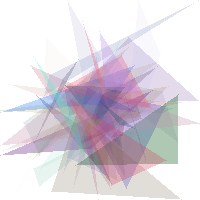

[0:00:34.107626] Iteration       50  ---  best_fitnesses [0.20946664]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


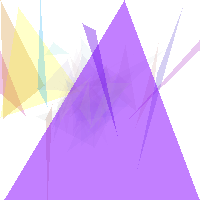

[0:00:41.495269] Iteration      100  ---  best_fitnesses [0.23506817]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


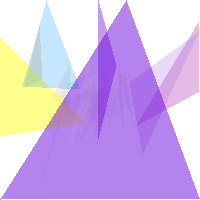

[0:00:48.864169] Iteration      150  ---  best_fitnesses [0.29446337]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


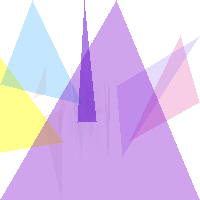

[0:00:56.239231] Iteration      200  ---  best_fitnesses [0.31282565]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


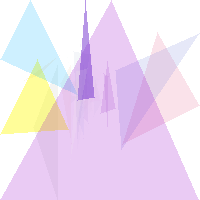

[0:01:03.592414] Iteration      250  ---  best_fitnesses [0.3251484]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


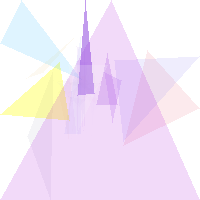

[0:01:10.899795] Iteration      300  ---  best_fitnesses [0.32794473]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


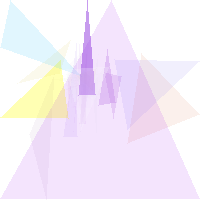

[0:01:18.245574] Iteration      350  ---  best_fitnesses [0.33208784]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


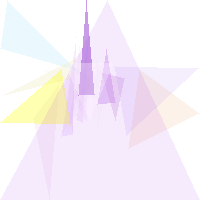

[0:01:25.770747] Iteration      400  ---  best_fitnesses [0.33604494]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


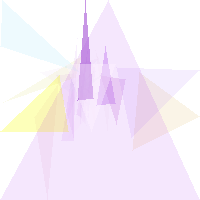

[0:01:33.111913] Iteration      450  ---  best_fitnesses [0.33792177]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


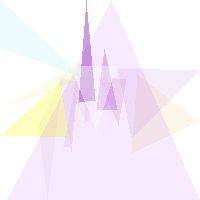

[0:01:40.437735] Iteration      500  ---  best_fitnesses [0.3418669]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


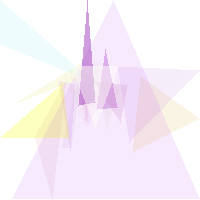

[0:01:47.880740] Iteration      550  ---  best_fitnesses [0.3466745]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


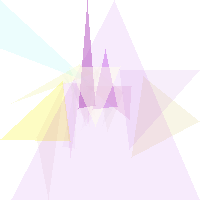

[0:01:55.272628] Iteration      600  ---  best_fitnesses [0.34474093]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


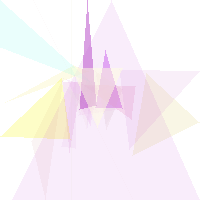

[0:02:02.619305] Iteration      650  ---  best_fitnesses [0.3461033]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


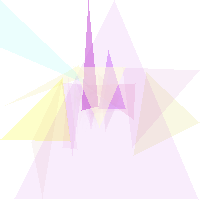

[0:02:09.971625] Iteration      700  ---  best_fitnesses [0.34561485]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


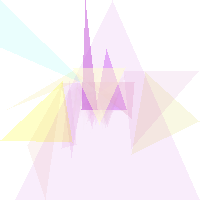

[0:02:17.453332] Iteration      750  ---  best_fitnesses [0.3449751]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


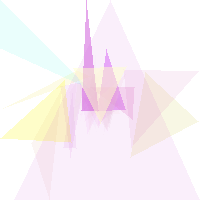

[0:02:24.831433] Iteration      800  ---  best_fitnesses [0.34938684]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


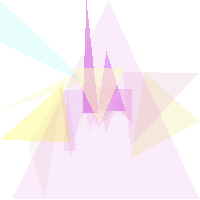

[0:02:32.180377] Iteration      850  ---  best_fitnesses [0.35010517]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


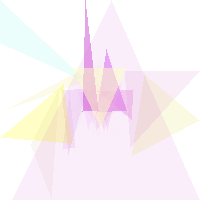

[0:02:39.565056] Iteration      900  ---  best_fitnesses [0.34647396]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


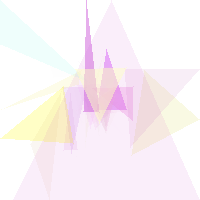

[0:02:46.895488] Iteration      950  ---  best_fitnesses [0.3514973]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


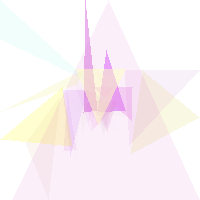

[0:02:54.254149] Iteration     1000  ---  best_fitnesses [0.35312256]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


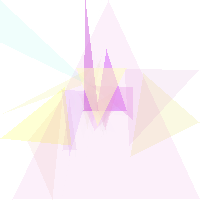

[0:03:01.581743] Iteration     1050  ---  best_fitnesses [0.35573506]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


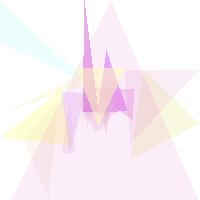

[0:03:08.942052] Iteration     1100  ---  best_fitnesses [0.3552433]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


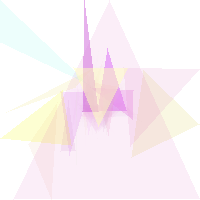

[0:03:16.285206] Iteration     1150  ---  best_fitnesses [0.35041583]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


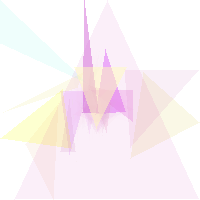

[0:03:23.640325] Iteration     1200  ---  best_fitnesses [0.35278207]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


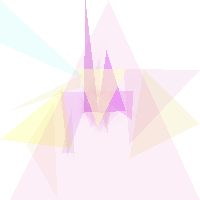

[0:03:30.973633] Iteration     1250  ---  best_fitnesses [0.35331273]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


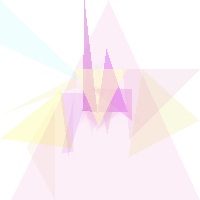

[0:03:38.304548] Iteration     1300  ---  best_fitnesses [0.35847735]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


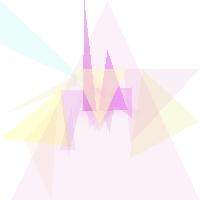

[0:03:45.654564] Iteration     1350  ---  best_fitnesses [0.3525303]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


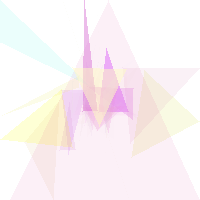

[0:03:53.040353] Iteration     1400  ---  best_fitnesses [0.3594096]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


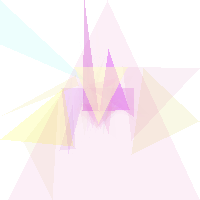

[0:04:00.354875] Iteration     1450  ---  best_fitnesses [0.3567176]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


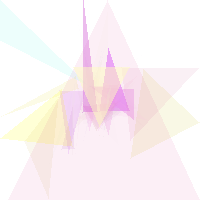

[0:04:07.677683] Iteration     1500  ---  best_fitnesses [0.35636294]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


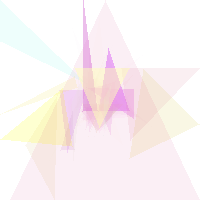

[0:04:15.062324] Iteration     1550  ---  best_fitnesses [0.35522923]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


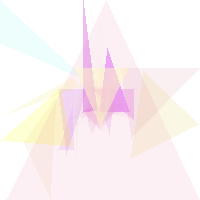

[0:04:22.402968] Iteration     1600  ---  best_fitnesses [0.35581052]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


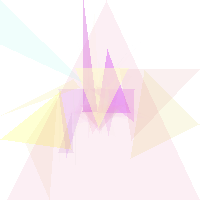

[0:04:29.730528] Iteration     1650  ---  best_fitnesses [0.3592366]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


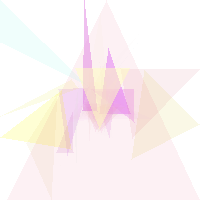

[0:04:37.073678] Iteration     1700  ---  best_fitnesses [0.36174536]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


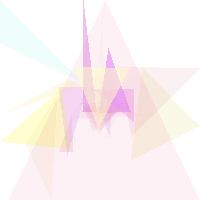

[0:04:44.392941] Iteration     1750  ---  best_fitnesses [0.36232352]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


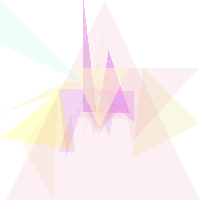

[0:04:51.715927] Iteration     1800  ---  best_fitnesses [0.35974008]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


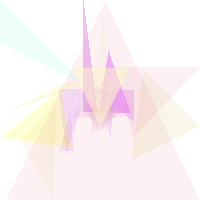

[0:04:59.035615] Iteration     1850  ---  best_fitnesses [0.35473636]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


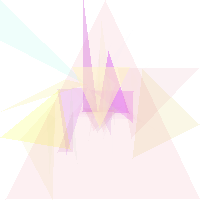

[0:05:06.354298] Iteration     1900  ---  best_fitnesses [0.36046976]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


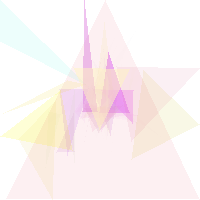

[0:05:13.732391] Iteration     1950  ---  best_fitnesses [0.36051577]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


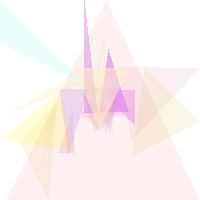

[0:05:21.101454] Iteration     2000  ---  best_fitnesses [0.35865867]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


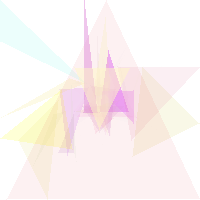

In [ ]:
main_loop()